In [2]:
import ast
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skfuzzy as fuzz
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet

c:\Users\Jack\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Some early cleaning of database.

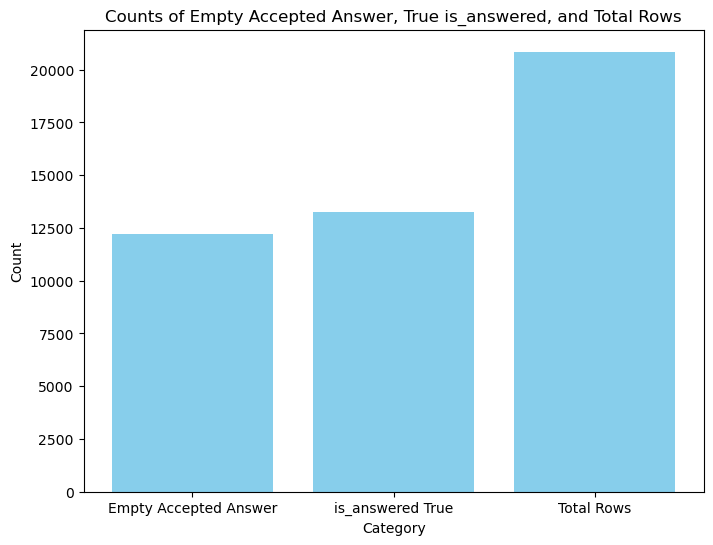

In [ ]:

# Read the CSV file
df = pd.read_csv("nlp_questions_with_accepted_answers.csv")

# Count the number of rows with an empty "Accepted Answer"
empty_accepted = df["Accepted Answer"].isnull() | (df["Accepted Answer"] == "")
empty_accepted_count = empty_accepted.sum()

# Count the number of rows where "is_answered" is True.
is_answered_true_count = df["is_answered"].astype(str).str.lower().eq("true").sum()

# Total number of rows in the DataFrame
total_rows = len(df)

# Data for plotting
categories = ["Empty Accepted Answer", "is_answered True", "Total Rows"]
counts = [empty_accepted_count, is_answered_true_count, total_rows]

# Create a column/bar graph
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color="skyblue")
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Counts of Empty Accepted Answer, True is_answered, and Total Rows")
plt.show()
# using code below to got rid of dataset without accepted answers as it wont be helpful to create the "system" as it wont help with answering the questrions.
# df_non_empty_accepted = df[~(df["Accepted Answer"].isnull() | (df["Accepted Answer"] == ""))]
# df_non_empty_accepted.to_csv("non_empty_accepted.csv", index=False)

# # Create second CSV by keeping only rows where "is_answered" is True.
# # This handles cases where the value may be a boolean or a string (like 'TRUE')
# df_answered_true = df[df["is_answered"].astype(str).str.lower().eq("true")]
# df_answered_true.to_csv("answered_true.csv", index=False)

preprocessing

In [4]:
def remove_html(text):
    return BeautifulSoup(text, "html.parser").get_text()

# Apply the HTML removal to every cell that is a string in the DataFrame
df_clean = df.applymap(lambda x: remove_html(x) if isinstance(x, str) else x)

# Save the cleaned DataFrame to a new CSV file
df_clean.to_csv("cleaned_database.csv", index=False)

C:\Users\Jack\AppData\Local\Temp\ipykernel_13228\1193552811.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_clean = df.applymap(lambda x: remove_html(x) if isinstance(x, str) else x)
C:\Users\Jack\AppData\Local\Temp\ipykernel_13228\1193552811.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Read the CSV file
df = pd.read_csv("cleaned_database.csv")# use cleaned_database

# Function to combine the specified columns into one sequence.
# This joins non-null text from "Title", "Description", and "Accepted Answer"
# with a separator that signals a new segment.
def combine_fields(row):
    fields = []
    for col in ["Title", "Description", "Accepted Answer"]:
        if pd.notnull(row[col]):
            fields.append(str(row[col]))
    # Join with the special [SEP] string.
    # When tokenizing, setting add_special_tokens=True will add [CLS] at the start and a final [SEP] automatically.
    # Here, inserting [SEP] manually between segments helps signal boundaries.
    return " [SEP] ".join(fields)

# Create a new column with the combined text.
df['combined_text'] = df.apply(combine_fields, axis=1)

# Tokenize the combined text for each row.
def tokenize_text(text):
    # The tokenizer adds special tokens ([CLS] and [SEP]) automatically.
    # It also handles truncation (if >512 tokens) and padding.
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,    # Adds [CLS] and [SEP]
        max_length=512,
        truncation=True,            # Truncate texts longer than max_length
        padding='max_length',       # Pad shorter texts to 512 tokens
        return_attention_mask=True,
        return_tensors='pt'         # Return PyTorch tensors (optional)
    )
    return encoded

# Apply tokenization to each combined text.
tokenized_data = df['combined_text'].apply(tokenize_text)

# Extract input_ids and attention_masks, converting tensors to lists.
df['input_ids'] = tokenized_data.apply(lambda x: x['input_ids'][0].tolist())
df['attention_mask'] = tokenized_data.apply(lambda x: x['attention_mask'][0].tolist())

# Optionally, save the updated DataFrame to a new CSV file.
df.to_csv("tokenized_database.csv", index=False)

putting into bert

In [9]:


# Load the pre-trained BERT model 
model = BertModel.from_pretrained('bert-base-cased')
model.eval()  # Set the model to evaluation mode

# Read the CSV file that contains the tokenized inputs (input_ids and attention_mask)
df = pd.read_csv("tokenized_database.csv")

# Convert string representations of lists back to actual lists
df['input_ids'] = df['input_ids'].apply(ast.literal_eval)
df['attention_mask'] = df['attention_mask'].apply(ast.literal_eval)

def get_cls_embedding(input_ids, attention_mask):
    """
    Given tokenized input_ids and attention_mask, return the [CLS] token embedding.
    """
    # Convert the lists into PyTorch tensors and add a batch dimension.
    input_ids_tensor = torch.tensor(input_ids).unsqueeze(0)        # shape: (1, seq_length)
    attention_mask_tensor = torch.tensor(attention_mask).unsqueeze(0)  # shape: (1, seq_length)
    
    with torch.no_grad():
        outputs = model(input_ids_tensor, attention_mask=attention_mask_tensor)
    # The last_hidden_state has shape (batch_size, sequence_length, hidden_size).
    # We take the first token ([CLS]) from each batch as the sentence embedding.
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, hidden_size)
    # Remove the batch dimension and convert to a list (or numpy array as needed)
    return cls_embedding.squeeze(0).tolist()

# Apply the function to each row to create an embedding column.
df['embedding'] = df.apply(lambda row: get_cls_embedding(row['input_ids'], row['attention_mask']), axis=1)

# Optionally, save the updated DataFrame to a new CSV file.
df.to_csv("bert_embeddings.csv", index=False)


visualise ebeding spcace

T-sne

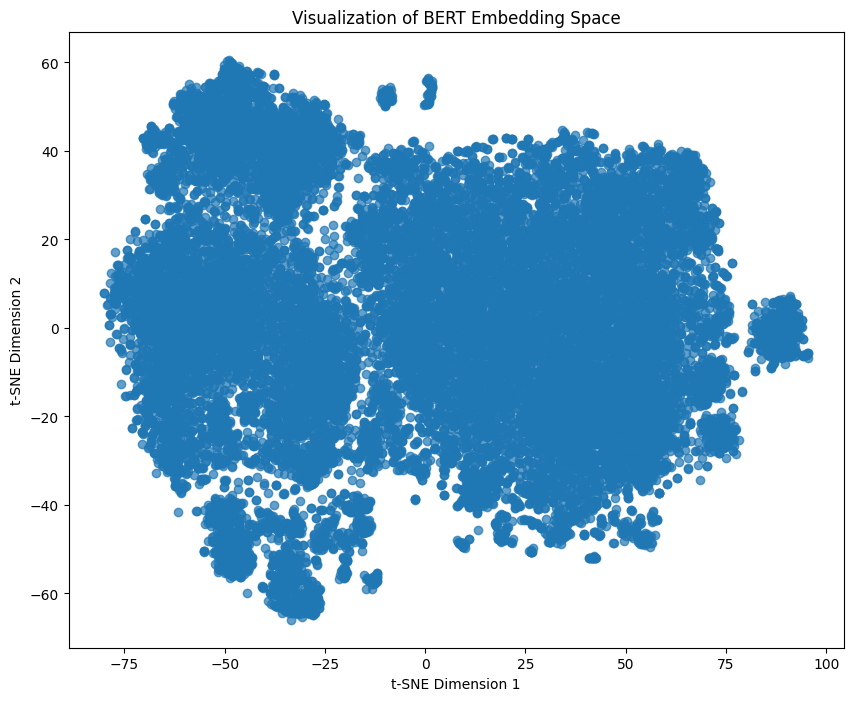

In [14]:
df = pd.read_csv("bert_embeddings.csv")

# Convert the 'embedding' column (stored as string) back to a list of floats.
df['embedding'] = df['embedding'].apply(ast.literal_eval)

# Create an array of embeddings.
embeddings = np.array(df['embedding'].tolist())

# Use t-SNE to reduce the dimensionality to 2 dimensions.
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the 2D embeddings using a scatter plot.
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("Visualization of BERT Embedding Space")
plt.show()

Umap

c:\Users\Jack\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


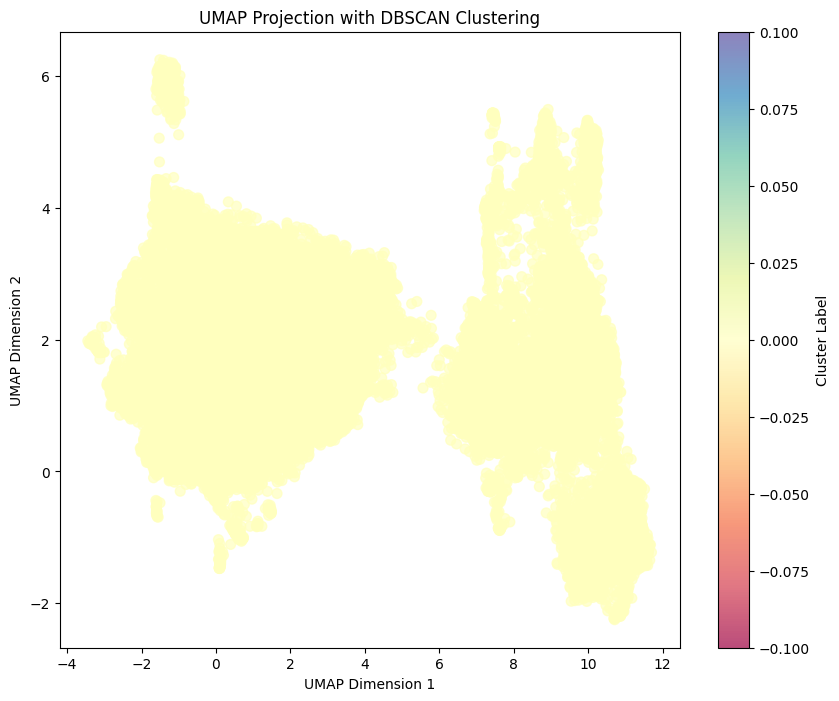

In [18]:


# Read the CSV file containing the embeddings.
df = pd.read_csv("bert_embeddings.csv")

# Convert the 'embedding' column (stored as a string) back to a list of floats.
df['embedding'] = df['embedding'].apply(ast.literal_eval)

# Create an array of embeddings.
embeddings = np.array(df['embedding'].tolist())

# Use UMAP to reduce dimensions to 2.
umap_reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = umap_reducer.fit_transform(embeddings)

# Apply DBSCAN to the 2D embeddings to get cluster labels.
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed.
cluster_labels = dbscan.fit_predict(embeddings_2d)

# Plot the 2D UMAP embedding with clusters.
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                      c=cluster_labels, cmap='Spectral', s=50, alpha=0.7)
plt.colorbar(scatter, label='Cluster Label')
plt.title("UMAP Projection with DBSCAN Clustering")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


PCA


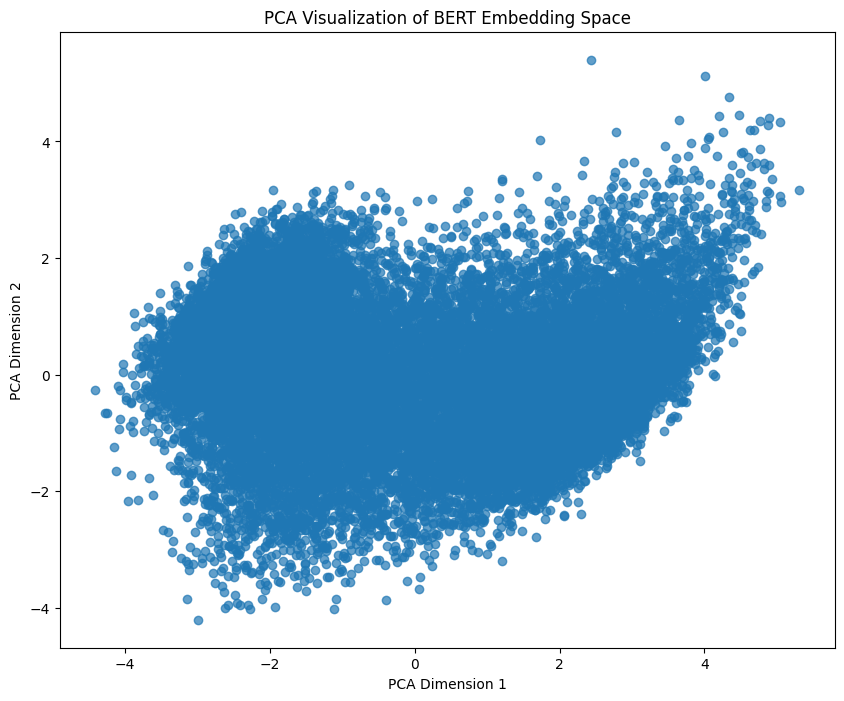

In [ ]:
df = pd.read_csv("bert_embeddings.csv")

# Convert the 'embedding' column (stored as a string) back to a list of floats.
df['embedding'] = df['embedding'].apply(ast.literal_eval)

# Create an array of embeddings.
embeddings = np.array(df['embedding'].tolist())

# Use PCA to reduce the dimensionality to 2 dimensions.
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the 2D PCA embedding.
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title("PCA Visualization of BERT Embedding Space")
plt.show()

Creates key word by analysing the dataset start with if a word have a high contextual meaning and appears in more then 10 rows it will be considered as a key word this will be used as categories 

Shape of X: (20855, 768)
Shape of X_transposed: (768, 20855)


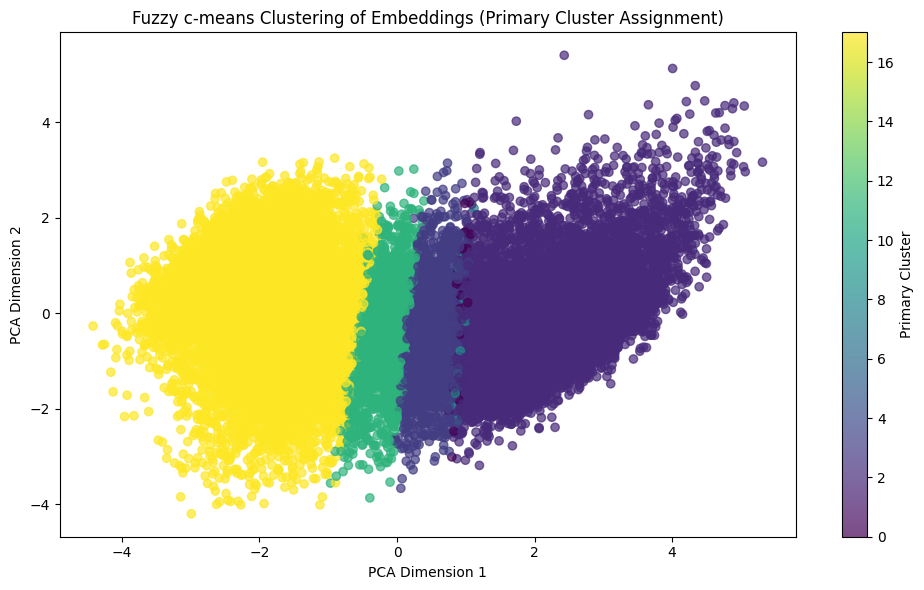

In [37]:

# 1. Load your CSV file
df = pd.read_csv("bert_embeddings.csv")

# 2. Convert the 'embedding' column (stored as a string) into a proper list of floats.
embedding_list = [ast.literal_eval(x) for x in df['embedding'].tolist()]
X = np.array(embedding_list, dtype=np.float64)
print("Shape of X:", X.shape)  # Expected shape: (num_samples, embedding_dim)

# 3. Transpose X for fuzzy c-means (expected shape: features x samples).
X_transposed = X.T
print("Shape of X_transposed:", X_transposed.shape)

# 4. Set fuzzy c-means parameters.
n_clusters = 20      # Adjust as needed.
m = 2.0             # Fuzziness parameter.
error = 0.005       # Convergence threshold.
maxiter = 1000      # Maximum number of iterations.

# 5. Create an initial membership matrix to help avoid division-by-zero.
#    The shape is (n_clusters, n_samples), and each column sums to 1.
n_samples = X_transposed.shape[1]
init_u = np.random.rand(n_clusters, n_samples)
init_u /= np.sum(init_u, axis=0, keepdims=True)

# 6. Run fuzzy c-means clustering with the explicit initial membership matrix.
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_transposed, c=n_clusters, m=m, error=error, maxiter=maxiter, init=init_u
)

# 7. Transpose membership matrix to shape (samples, clusters).
membership = u.T

# 8. Define a threshold and helper function to assign clusters.
threshold = 0.1
def get_cluster_labels(row_membership, threshold=threshold):
    clusters = [int(i) for i, prob in enumerate(row_membership) if prob > threshold]
    # If no cluster exceeds the threshold, assign the cluster with the highest membership.
    if not clusters:
        clusters = [int(np.argmax(row_membership))]
    return clusters

# 9. Create a new column 'cluster_array' with the cluster indices for each row.
df['cluster_array'] = [get_cluster_labels(row) for row in membership]

# 10. Save the updated DataFrame to a new CSV.
df.to_csv("clustered_output.csv", index=False)

# 11. (Optional) Visualize the clusters using PCA (if embedding_dim > 1).
if X.shape[1] > 1:
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    
    # Use the primary cluster (max membership) for color-coding.
    primary_clusters = np.argmax(membership, axis=1)
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        X_reduced[:, 0], X_reduced[:, 1],
        c=primary_clusters, cmap="viridis", alpha=0.7
    )
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.title("Fuzzy c-means Clustering of Embeddings (Primary Cluster Assignment)")
    plt.colorbar(scatter, label="Primary Cluster")
    plt.tight_layout()
    plt.savefig("fuzzy_embedding_clusters.png")
    plt.show()
else:
    print("Skipping PCA visualization because embeddings are 1D.")

using HDBSCAN to determin the cluster and using centroid and cosine simlarity to determin which text is at the center of the embdeing space

Shape of X: (20855, 768)
Unique clusters found: [-1  0  1  2]
Representative sentences for each cluster:
Cluster 0: Custom WordNet in NLTK [SEP] So, I have an xml file that is formatted with as wordNet with Synsets and Synonyms and other tags. I need to use this xml file to get things like word similarites etc. So, I want to use nltk to read and convert this xml to a custom wordNet type of thing. I know I can use the XmlCorpusReader to create corpus out of xml, but I couln't figure out how to use the corpus to create the wornet and use functions like path_similarity etc. Is it possible to do this with nltk, if it is how should I proceed?
Thank you

Cluster 1: Trying to use MEGAM as an NLTK ClassifierBasedPOSTagger? [SEP] I am currently trying to build a general purpose (or as general as is practical) POS tagger with NLTK. I have dabbled with the brown and treebank corpora for training, but will probably be settling on the treebank corpus.
Learning as I go, I am finding the classifier P

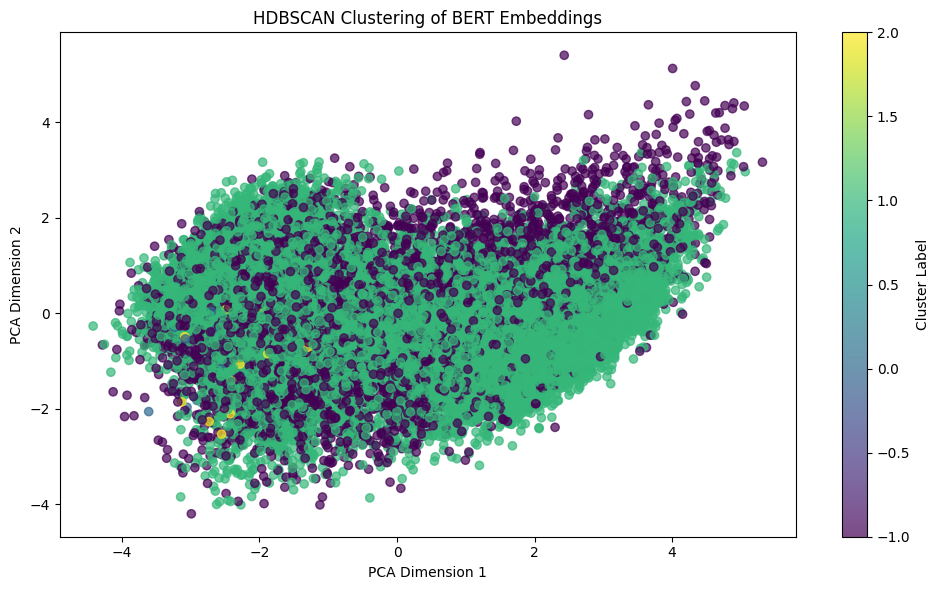

In [5]:

from sklearn.metrics.pairwise import cosine_similarity

# 1. Load the CSV file (ensure your CSV has 'embedding' and 'sentence' columns)
df = pd.read_csv("bert_embeddings.csv")

# 2. Convert the 'embedding' column (stored as strings) to a list of floats
embedding_list = [ast.literal_eval(x) for x in df['embedding'].tolist()]
X = np.array(embedding_list, dtype=np.float64)
print("Shape of X:", X.shape)  # Expected shape: (num_samples, embedding_dim)

# 3. Cluster the embeddings using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=1)
cluster_labels = clusterer.fit_predict(X)
df['cluster'] = cluster_labels  # -1 indicates noise
print("Unique clusters found:", np.unique(cluster_labels))

# 4. Compute centroids for each cluster (ignoring noise, i.e., label -1)
unique_labels = np.unique(cluster_labels)
centroids = {}
for label in unique_labels:
    if label == -1:
        continue  # Skip noise if desired
    indices = np.where(cluster_labels == label)[0]
    cluster_embeddings = X[indices]
    centroid = np.mean(cluster_embeddings, axis=0)
    centroids[label] = centroid

# 5. For each cluster, find the sentence with the highest cosine similarity to the centroid
representative_sentences = {}

for label, centroid in centroids.items():
    # Get the indices and embeddings for all sentences in the cluster
    indices = np.where(cluster_labels == label)[0]
    cluster_embeddings = X[indices]
    
    # Compute cosine similarities between the centroid and each embedding in the cluster.
    # Reshape centroid to 2D for the function.
    sims = cosine_similarity([centroid], cluster_embeddings)[0]
    
    # Get the index of the sentence with the highest similarity
    best_idx_within_cluster = np.argmax(sims)
    best_global_idx = indices[best_idx_within_cluster]
    
    representative_sentence = df.iloc[best_global_idx]['combined_text']
    representative_sentences[label] = representative_sentence

print("Representative sentences for each cluster:")
for label, sentence in representative_sentences.items():
    print(f"Cluster {label}: {sentence}")

# 6. (Optional) Save the DataFrame with clusters to a CSV
df.to_csv("hdbscan_clustered_output.csv", index=False)

# 7. (Optional) Visualize the clusters using PCA
if X.shape[1] > 1:
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_labels, cmap="viridis", alpha=0.7)
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.title("HDBSCAN Clustering of BERT Embeddings")
    plt.colorbar(scatter, label="Cluster Label")
    plt.tight_layout()
    plt.savefig("hdbscan_embedding_clusters.png")
    plt.show()
else:
    print("Skipping PCA visualization because embeddings are 1D.")


key word extraction for each cluster

In [15]:
df = pd.read_csv("hdbscan_clustered_output.csv")

# 2. Specify the text column that you want to extract keywords from.
# Change "word label" to the appropriate column name if different.
text_column = "combined_text"

# 3. Group data by cluster label (skipping noise if desired).
cluster_texts = {}
for label, group in df.groupby("cluster"):
    if label == -1:
        continue  # Optionally skip noise
    combined_text = " ".join(group[text_column].tolist())
    cluster_texts[label] = combined_text

# 4. For each cluster, extract the top 5 keywords using TF-IDF.
cluster_keywords = {}
for label, text in cluster_texts.items():
    vectorizer = TfidfVectorizer(stop_words='english', max_features=50)
    tfidf_matrix = vectorizer.fit_transform([text])
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()[0]
    top_indices = np.argsort(tfidf_scores)[::-1][:20]  # Top 5 keywords
    keywords = [feature_names[i] for i in top_indices]
    cluster_keywords[label] = keywords

print("Keywords for each cluster before filtering:")
for label, keywords in cluster_keywords.items():
    print(f"Cluster {label}: {keywords}")

# 5. Remove keywords that appear in every cluster.
all_keywords = []
for kw_list in cluster_keywords.values():
    all_keywords.extend(kw_list)
keyword_counter = Counter(all_keywords)
n_clusters = len(cluster_keywords)

filtered_cluster_keywords = {}
for label, kw_list in cluster_keywords.items():
    filtered_keywords = [kw for kw in kw_list if keyword_counter[kw] < n_clusters]
    filtered_cluster_keywords[label] = filtered_keywords

print("\nFiltered Keywords for each cluster (removing common words):")
for label, keywords in filtered_cluster_keywords.items():
    print(f"Cluster {label}: {keywords}")

# 6. Record how often each keyword appears in its cluster.
#    We'll perform a simple count on the aggregated text.
keyword_frequencies = {}
for label, text in cluster_texts.items():
    # Lowercase and split the text to count words.
    tokens = text.lower().split()
    # Count frequency for each keyword in the filtered list for that cluster.
    freqs = {}
    for kw in filtered_cluster_keywords.get(label, []):
        freqs[kw] = tokens.count(kw)
    keyword_frequencies[label] = freqs

print("\nKeyword frequencies for each cluster:")
for label, freq_dict in keyword_frequencies.items():
    print(f"Cluster {label}: {freq_dict}")


Keywords for each cluster before filtering:
Cluster 0: ['text', 'sep', 'thank', 'model', 'use', 'word', 'need', 'new', 'words', 'data', 'using', 'like', 'python', 'create', 'df', 'file', 'nltk', 'nlp', 'code', 'dependency']
Cluster 1: ['text', 'model', 'sep', 'word', 'import', 'self', 'words', 'data', 'using', 'file', 'use', 'print', 'like', 'nlp', 'sentence', 'code', 'list', 'return', 'nltk', 'python']
Cluster 2: ['advance', 'sep', 'using', 'thanks', 'nlp', 'word', 'words', 'list', 'model', 'python', 'way', 'want', 'data', 'like', 'sentence', 'natural', 'summary', 'text', 'spacy', 'nltk']

Filtered Keywords for each cluster (removing common words):
Cluster 0: ['thank', 'use', 'need', 'new', 'create', 'df', 'file', 'code', 'dependency']
Cluster 1: ['import', 'self', 'file', 'use', 'print', 'sentence', 'code', 'list', 'return']
Cluster 2: ['advance', 'thanks', 'list', 'way', 'want', 'sentence', 'natural', 'summary', 'spacy']

Keyword frequencies for each cluster:
Cluster 0: {'thank': 35

create a new more clean data base where stop word will be removed this will then gone through the same process as above in therory this could create a better embeding layer which we can combine with the previous to create sub cluster(sub categories)

In [ ]:
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    """Remove English stopwords from a text string."""
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return " ".join(filtered_tokens)

# Load the cleaned CSV (this file already has HTML removed, etc.)
df = pd.read_csv("cleaned_database.csv")

# Apply stop word removal to every cell that is a string.
df_clean_no_stop = df.applymap(lambda x: remove_stopwords(x) if isinstance(x, str) else x)

# Save the new, further cleaned DataFrame to a CSV.
df_clean_no_stop.to_csv("more_cleaned_database.csv", index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jack/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Read the CSV file
df = pd.read_csv("more_cleaned_database.csv")# use cleaned_database

# Function to combine the specified columns into one sequence.
# This joins non-null text from "Title", "Description", and "Accepted Answer"
# with a separator that signals a new segment.
def combine_fields(row):
    fields = []
    for col in ["Title", "Description", "Accepted Answer"]:
        if pd.notnull(row[col]):
            fields.append(str(row[col]))
    # Join with the special [SEP] string.
    # When tokenizing, setting add_special_tokens=True will add [CLS] at the start and a final [SEP] automatically.
    # Here, inserting [SEP] manually between segments helps signal boundaries.
    return " [SEP] ".join(fields)

# Create a new column with the combined text.
df['combined_text'] = df.apply(combine_fields, axis=1)

# Tokenize the combined text for each row.
def tokenize_text(text):
    # The tokenizer adds special tokens ([CLS] and [SEP]) automatically.
    # It also handles truncation (if >512 tokens) and padding.
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,    # Adds [CLS] and [SEP]
        max_length=512,
        truncation=True,            # Truncate texts longer than max_length
        padding='max_length',       # Pad shorter texts to 512 tokens
        return_attention_mask=True,
        return_tensors='pt'         # Return PyTorch tensors (optional)
    )
    return encoded

# Apply tokenization to each combined text.
tokenized_data = df['combined_text'].apply(tokenize_text)

# Extract input_ids and attention_masks, converting tensors to lists.
df['input_ids'] = tokenized_data.apply(lambda x: x['input_ids'][0].tolist())
df['attention_mask'] = tokenized_data.apply(lambda x: x['attention_mask'][0].tolist())

# Optionally, save the updated DataFrame to a new CSV file.
df.to_csv("more_clean_tokenized_database.csv", index=False)

In [23]:
# Load the pre-trained BERT model 
model = BertModel.from_pretrained('bert-base-cased')
model.eval()  # Set the model to evaluation mode

# Read the CSV file that contains the tokenized inputs (input_ids and attention_mask)
df = pd.read_csv("more_clean_tokenized_database.csv")

# Convert string representations of lists back to actual lists
df['input_ids'] = df['input_ids'].apply(ast.literal_eval)
df['attention_mask'] = df['attention_mask'].apply(ast.literal_eval)

def get_cls_embedding(input_ids, attention_mask):
    """
    Given tokenized input_ids and attention_mask, return the [CLS] token embedding.
    """
    # Convert the lists into PyTorch tensors and add a batch dimension.
    input_ids_tensor = torch.tensor(input_ids).unsqueeze(0)        # shape: (1, seq_length)
    attention_mask_tensor = torch.tensor(attention_mask).unsqueeze(0)  # shape: (1, seq_length)
    
    with torch.no_grad():
        outputs = model(input_ids_tensor, attention_mask=attention_mask_tensor)
    # The last_hidden_state has shape (batch_size, sequence_length, hidden_size).
    # We take the first token ([CLS]) from each batch as the sentence embedding.
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, hidden_size)
    # Remove the batch dimension and convert to a list (or numpy array as needed)
    return cls_embedding.squeeze(0).tolist()

# Apply the function to each row to create an embedding column.
df['embedding'] = df.apply(lambda row: get_cls_embedding(row['input_ids'], row['attention_mask']), axis=1)

# Optionally, save the updated DataFrame to a new CSV file.
df.to_csv("more_clean_bert_embeddings.csv", index=False)


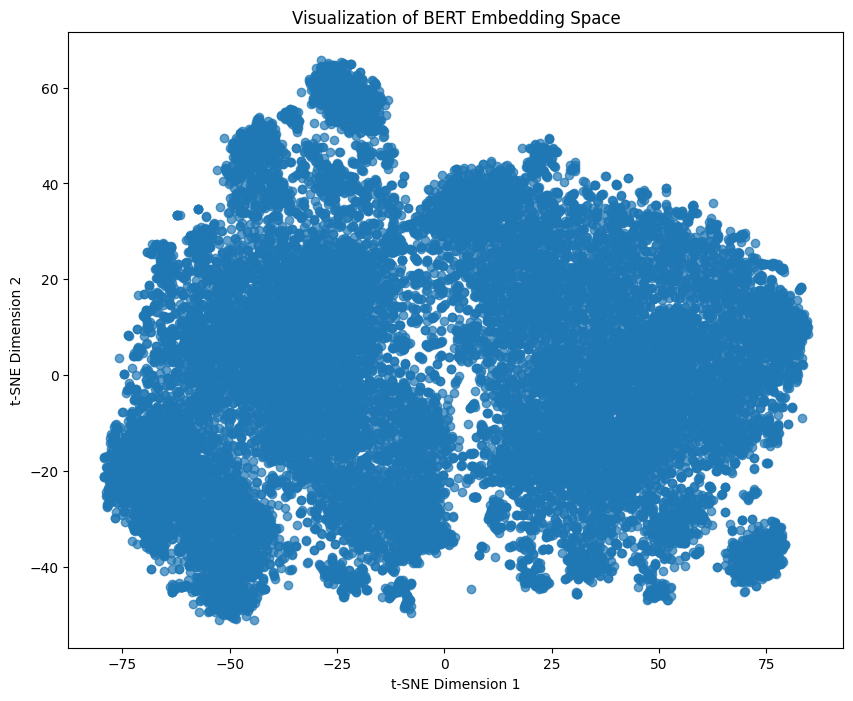

In [24]:
df = pd.read_csv("more_clean_bert_embeddings.csv")

# Convert the 'embedding' column (stored as string) back to a list of floats.
df['embedding'] = df['embedding'].apply(ast.literal_eval)

# Create an array of embeddings.
embeddings = np.array(df['embedding'].tolist())

# Use t-SNE to reduce the dimensionality to 2 dimensions.
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the 2D embeddings using a scatter plot.
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("Visualization of BERT Embedding Space")
plt.show()

Shape of X: (20855, 768)
Unique clusters found: [-1  0  1  2  3  4]
Representative sentences for each cluster:
Cluster 0: Search job titles article using Spacy NLTK [SEP] new NLP recently playing NTLK Spacy. However, could find way search job titles (ex: product manager, chief marketing officer, etc) article. Example, 1000 articles want get articles job titles interested in. Also, entity type job titles fall in? check https://spacy.io/docs/usage/entity-recognition see there. plan add it? Thanks.
Cluster 1: get inconsistent results Fasttext, Longformer, Doc2vec? [SEP] using Doc2Vec model calculate cosine similarity observations dataset website text. want sure measure roughly consistent instead use Fasttext (trained data) Longformer (pre-trained) [I know identical]. However, pairwise cosine similarity measure strongly negatively correlated Doc2Vec & Longformer Doc2Vec & Fasttext. measure positively correlated Longformer & Fasttext. reason one might expect this? mistakenly something code 

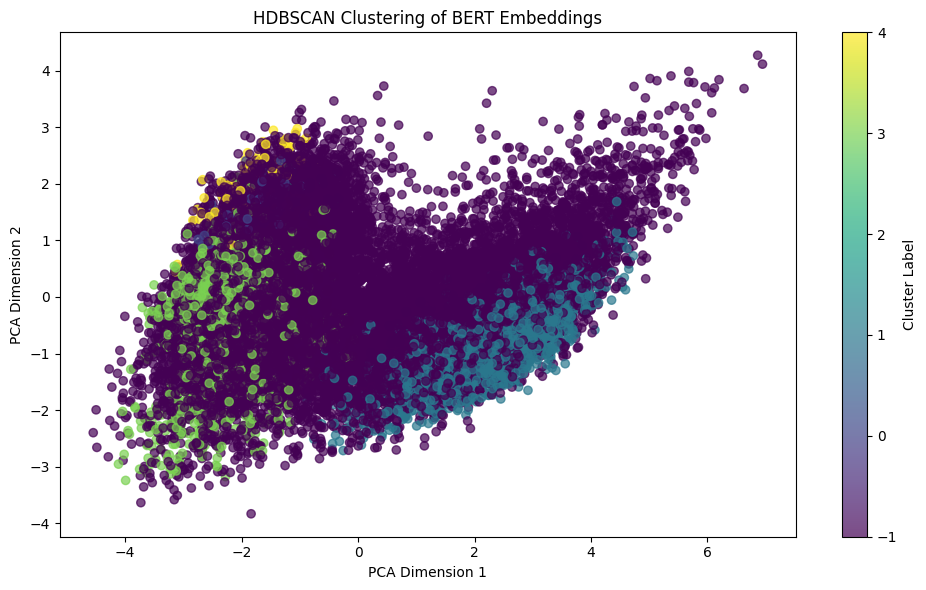

In [27]:
df = pd.read_csv("more_clean_bert_embeddings.csv")

# 2. Convert the 'embedding' column (stored as strings) to a list of floats
embedding_list = [ast.literal_eval(x) for x in df['embedding'].tolist()]
X = np.array(embedding_list, dtype=np.float64)
print("Shape of X:", X.shape)  # Expected shape: (num_samples, embedding_dim)

# 3. Cluster the embeddings using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=1)
cluster_labels = clusterer.fit_predict(X)
df['cluster'] = cluster_labels  # -1 indicates noise
print("Unique clusters found:", np.unique(cluster_labels))

# 4. Compute centroids for each cluster (ignoring noise, i.e., label -1)
unique_labels = np.unique(cluster_labels)
centroids = {}
for label in unique_labels:
    if label == -1:
        continue  # Skip noise if desired
    indices = np.where(cluster_labels == label)[0]
    cluster_embeddings = X[indices]
    centroid = np.mean(cluster_embeddings, axis=0)
    centroids[label] = centroid

# 5. For each cluster, find the sentence with the highest cosine similarity to the centroid
representative_sentences = {}

for label, centroid in centroids.items():
    # Get the indices and embeddings for all sentences in the cluster
    indices = np.where(cluster_labels == label)[0]
    cluster_embeddings = X[indices]
    
    # Compute cosine similarities between the centroid and each embedding in the cluster.
    # Reshape centroid to 2D for the function.
    sims = cosine_similarity([centroid], cluster_embeddings)[0]
    
    # Get the index of the sentence with the highest similarity
    best_idx_within_cluster = np.argmax(sims)
    best_global_idx = indices[best_idx_within_cluster]
    
    representative_sentence = df.iloc[best_global_idx]['combined_text']
    representative_sentences[label] = representative_sentence

print("Representative sentences for each cluster:")
for label, sentence in representative_sentences.items():
    print(f"Cluster {label}: {sentence}")

# 6. (Optional) Save the DataFrame with clusters to a CSV
df.to_csv("more_clean_hdbscan_clustered_output.csv", index=False)

# 7. (Optional) Visualize the clusters using PCA
if X.shape[1] > 1:
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_labels, cmap="viridis", alpha=0.7)
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.title("HDBSCAN Clustering of BERT Embeddings")
    plt.colorbar(scatter, label="Cluster Label")
    plt.tight_layout()
    plt.savefig("more_clean_hdbscan_embedding_clusters.png")
    plt.show()
else:
    print("Skipping PCA visualization because embeddings are 1D.")


In [28]:
df = pd.read_csv("more_clean_hdbscan_clustered_output.csv")

# 2. Specify the text column that you want to extract keywords from.
# Change "word label" to the appropriate column name if different.
text_column = "combined_text"

# 3. Group data by cluster label (skipping noise if desired).
cluster_texts = {}
for label, group in df.groupby("cluster"):
    if label == -1:
        continue  # Optionally skip noise
    combined_text = " ".join(group[text_column].tolist())
    cluster_texts[label] = combined_text

# 4. For each cluster, extract the top 5 keywords using TF-IDF.
cluster_keywords = {}
for label, text in cluster_texts.items():
    vectorizer = TfidfVectorizer(stop_words='english', max_features=50)
    tfidf_matrix = vectorizer.fit_transform([text])
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()[0]
    top_indices = np.argsort(tfidf_scores)[::-1][:20]  # Top 5 keywords
    keywords = [feature_names[i] for i in top_indices]
    cluster_keywords[label] = keywords

print("Keywords for each cluster before filtering:")
for label, keywords in cluster_keywords.items():
    print(f"Cluster {label}: {keywords}")

# 5. Remove keywords that appear in every cluster.
all_keywords = []
for kw_list in cluster_keywords.values():
    all_keywords.extend(kw_list)
keyword_counter = Counter(all_keywords)
n_clusters = len(cluster_keywords)

filtered_cluster_keywords = {}
for label, kw_list in cluster_keywords.items():
    filtered_keywords = [kw for kw in kw_list if keyword_counter[kw] < n_clusters]
    filtered_cluster_keywords[label] = filtered_keywords

print("\nFiltered Keywords for each cluster (removing common words):")
for label, keywords in filtered_cluster_keywords.items():
    print(f"Cluster {label}: {keywords}")

# 6. Record how often each keyword appears in its cluster.
#    We'll perform a simple count on the aggregated text.
keyword_frequencies = {}
for label, text in cluster_texts.items():
    # Lowercase and split the text to count words.
    tokens = text.lower().split()
    # Count frequency for each keyword in the filtered list for that cluster.
    freqs = {}
    for kw in filtered_cluster_keywords.get(label, []):
        freqs[kw] = tokens.count(kw)
    keyword_frequencies[label] = freqs

print("\nKeyword frequencies for each cluster:")
for label, freq_dict in keyword_frequencies.items():
    print(f"Cluster {label}: {freq_dict}")


Keywords for each cluster before filtering:
Cluster 0: ['sep', 'words', 'model', 'like', 'text', 'using', 'thanks', 'data', 'use', 'way', 'thank', 'want', 'language', 'python', 'sentence', 'know', 'nlp', 'need', 'training', 'question']
Cluster 1: ['self', 'model', 'import', 'text', 'file', 'data', 'return', 'print', 'word', 'line', 'py', 'sep', 'tf', 'def', 'true', 'words', 'lib', 'code', 'nlp', 'packages']
Cluster 2: ['model', 'text', 'sep', 'using', 'word', 'documents', 'output', 'training', 'document', 'words', 'like', 'sentence', 'similarity', 'data', 'dataset', 'models', 'nlp', 'use', 'used', 'embeddings']
Cluster 3: ['sep', 'text', 'model', 'words', 'word', 'using', 'use', 'like', 'data', 'want', 'sentence', 'nlp', 'way', 'example', 'need', 'nltk', 'sentences', 'language', 'list', 'spacy']
Cluster 4: ['sep', 'text', 'thanks', 'using', 'words', 'model', 'nlp', 'like', 'data', 'way', 'want', 'word', 'use', 'spacy', 'know', 'sentence', 'need', 'python', 'example', 'trying']

Filtere

In [3]:
# Custom domain whitelist for coding and NLP terms.
domain_whitelist = {
    # Coding fundamentals
    "algorithm", "api", "array", "argument", "assert", "async", "attribute", "binary",
    "bit", "boolean", "branch", "buffer", "cache", "callback", "class", "client", "code",
    "compile", "compiler", "constant", "data", "database", "debug", "declaration",
    "dependency", "destructor", "dictionary", "directory", "document", "exception",
    "expression", "file", "function", "framework", "hash", "html", "identifier", "if",
    "import", "index", "inheritance", "instance", "integer", "interface", "iteration",
    "json", "keyword", "library", "loop", "object", "operator", "output", "package",
    "parameter", "pointer", "polymorphism", "process", "program", "protocol", "python",
    "query", "queue", "recursion", "regex", "repository", "return", "runtime", "scope",
    "script", "server", "stack", "string", "structure", "subroutine", "syntax", "table",
    "tag", "thread", "token", "tuple", "variable", "virtual", "version", "xml", "csv",
    
    # NLP and text processing
    "tokenization", "nlp", "linguistic", "stemming", "lemmatization", "embedding",
    "bert", "gpt", "transformer", "pos", "parsing", "dependency", "semantic",
    "syntactic", "corpus", "stopword", "vectorization", "tfidf", "word2vec", "glove",
    "context", "sequence",
    
    # Neural network and deep learning
    "neural", "network", "rnn", "lstm", "gru", "attention", "selfattention", "encoder",
    "decoder", "fine-tuning", "pretraining", "model", "classification", "regression",
    "clustering", "feature", "extraction", "dimensionality", "pca", "umap", "tsne",
    "optimization", "gradient", "backpropagation", "learning", "training", "validation",
    "test", "dataset", "augmentation", "overfitting", "regularization", "loss", "metric",
    "evaluation", "accuracy", "precision", "recall", "f1", "score", "contextual"
}


In [36]:
df = pd.read_csv("more_clean_hdbscan_clustered_output.csv")

# 2. Specify the text column to use.
text_column = "combined_text"

# 3. Group the text by cluster (skip noise, e.g. cluster -1).
cluster_texts = {}
for label, group in df.groupby("cluster"):
    if label == -1:
        continue  # Skip noise if desired.
    combined_text = " ".join(group[text_column].tolist())
    cluster_texts[label] = combined_text

# 4. For each cluster, filter tokens to only those in the whitelist and count frequencies.
cluster_keyword_freq = {}
for label, text in cluster_texts.items():
    tokens = text.split()  # simple whitespace split
    # Keep only tokens in the custom domain whitelist.
    filtered_tokens = [token for token in tokens if token in domain_whitelist]
    freq_counter = Counter(filtered_tokens)
    # Get the top 20 words by frequency.
    top_20 = freq_counter.most_common(20)
    cluster_keyword_freq[label] = dict(top_20)

print("Top 20 domain-specific words by frequency for each cluster:")
for label, freq_dict in cluster_keyword_freq.items():
    print(f"Cluster {label}: {freq_dict}")

# 5. Determine common words that appear in the top 20 for every cluster.
top_words_sets = [set(freq.keys()) for freq in cluster_keyword_freq.values()]
common_words = set.intersection(*top_words_sets) if top_words_sets else set()

print("\nCommon words appearing in all clusters:", common_words)

# 6. Remove these common words from each cluster's top keywords.
filtered_cluster_keyword_freq = {}
for label, freq_dict in cluster_keyword_freq.items():
    filtered = {word: count for word, count in freq_dict.items() if word not in common_words}
    filtered_cluster_keyword_freq[label] = filtered

print("\nFiltered Top 20 (common words removed) for each cluster:")
for label, freq_dict in filtered_cluster_keyword_freq.items():
    print(f"Cluster {label}: {freq_dict}")

Top 20 domain-specific words by frequency for each cluster:
Cluster 0: {'model': 43, 'data': 34, 'training': 21, 'file': 17, 'algorithm': 17, 'python': 14, 'corpus': 13, 'library': 11, 'document': 10, 'string': 9, 'sequence': 9, 'embedding': 7, 'token': 7, 'dataset': 6, 'learning': 6, 'test': 6, 'output': 5, 'package': 5, 'bit': 5, 'code': 5}
Cluster 1: {'import': 7834, 'return': 4435, 'model': 4350, 'data': 2175, 'code': 2136, 'output': 1412, 'training': 1205, 'file': 1162, 'class': 1110, 'function': 985, 'dataset': 809, 'string': 744, 'token': 705, 'loss': 694, 'object': 625, 'test': 509, 'embedding': 507, 'document': 496, 'corpus': 488, 'python': 446}
Cluster 2: {'model': 13, 'output': 11, 'training': 10, 'document': 7, 'embedding': 5, 'dataset': 4, 'classification': 3, 'learning': 3, 'data': 3, 'code': 3, 'iteration': 3, 'score': 3, 'file': 3, 'metric': 2, 'corpus': 2, 'accuracy': 2, 'dependency': 2, 'feature': 2, 'extraction': 2, 'neural': 1}
Cluster 3: {'model': 995, 'data': 708,

In [5]:
#nltk.download('stopwords')
def filter_to_whitelist(text):
    """
    Splits the text on whitespace and retains only those tokens
    that are present in the custom domain whitelist.
    """
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() in domain_whitelist]
    return " ".join(filtered_tokens)

# Load the cleaned CSV file.
df = pd.read_csv("more_cleaned_database.csv")

# Apply the whitelist filtering to every cell that is a string.
df_filtered = df.applymap(lambda x: filter_to_whitelist(x) if isinstance(x, str) else x)

# Save the resulting DataFrame to a new CSV file.
df_filtered.to_csv("More_more_cleaned_database.csv", index=False)

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Read the CSV file
df = pd.read_csv("More_more_cleaned_database.csv")# use cleaned_database

# Function to combine the specified columns into one sequence.
# This joins non-null text from "Title", "Description", and "Accepted Answer"
# with a separator that signals a new segment.
def combine_fields(row):
    fields = []
    for col in ["Title", "Description", "Accepted Answer"]:
        if pd.notnull(row[col]):
            fields.append(str(row[col]))
    # Join with the special [SEP] string.
    # When tokenizing, setting add_special_tokens=True will add [CLS] at the start and a final [SEP] automatically.
    # Here, inserting [SEP] manually between segments helps signal boundaries.
    return " [SEP] ".join(fields)

# Create a new column with the combined text.
df['combined_text'] = df.apply(combine_fields, axis=1)

# Tokenize the combined text for each row.
def tokenize_text(text):
    # The tokenizer adds special tokens ([CLS] and [SEP]) automatically.
    # It also handles truncation (if >512 tokens) and padding.
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,    # Adds [CLS] and [SEP]
        max_length=512,
        truncation=True,            # Truncate texts longer than max_length
        padding='max_length',       # Pad shorter texts to 512 tokens
        return_attention_mask=True,
        return_tensors='pt'         # Return PyTorch tensors (optional)
    )
    return encoded

# Apply tokenization to each combined text.
tokenized_data = df['combined_text'].apply(tokenize_text)

# Extract input_ids and attention_masks, converting tensors to lists.
df['input_ids'] = tokenized_data.apply(lambda x: x['input_ids'][0].tolist())
df['attention_mask'] = tokenized_data.apply(lambda x: x['attention_mask'][0].tolist())

# Optionally, save the updated DataFrame to a new CSV file.
df.to_csv("More_more_clean_tokenized_database.csv", index=False)

In [ ]:
# Load the pre-trained BERT model 
model = BertModel.from_pretrained('bert-base-cased')
model.eval()  # Set the model to evaluation mode

# Read the CSV file that contains the tokenized inputs (input_ids and attention_mask)
df = pd.read_csv("More_more_clean_tokenized_database.csv")

# Convert string representations of lists back to actual lists
df['input_ids'] = df['input_ids'].apply(ast.literal_eval)
df['attention_mask'] = df['attention_mask'].apply(ast.literal_eval)

def get_cls_embedding(input_ids, attention_mask):
    """
    Given tokenized input_ids and attention_mask, return the [CLS] token embedding.
    """
    # Convert the lists into PyTorch tensors and add a batch dimension.
    input_ids_tensor = torch.tensor(input_ids).unsqueeze(0)        # shape: (1, seq_length)
    attention_mask_tensor = torch.tensor(attention_mask).unsqueeze(0)  # shape: (1, seq_length)
    
    with torch.no_grad():
        outputs = model(input_ids_tensor, attention_mask=attention_mask_tensor)
    # The last_hidden_state has shape (batch_size, sequence_length, hidden_size).
    # We take the first token ([CLS]) from each batch as the sentence embedding.
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, hidden_size)
    # Remove the batch dimension and convert to a list (or numpy array as needed)
    return cls_embedding.squeeze(0).tolist()

# Apply the function to each row to create an embedding column.
df['embedding'] = df.apply(lambda row: get_cls_embedding(row['input_ids'], row['attention_mask']), axis=1)

# Optionally, save the updated DataFrame to a new CSV file.
df.to_csv("More_more_clean_bert_embeddings.csv", index=False)

In [ ]:
df = pd.read_csv("More_more_clean_bert_embeddings.csv")

# Convert the 'embedding' column (stored as string) back to a list of floats.
df['embedding'] = df['embedding'].apply(ast.literal_eval)

# Create an array of embeddings.
embeddings = np.array(df['embedding'].tolist())

# Use t-SNE to reduce the dimensionality to 2 dimensions.
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the 2D embeddings using a scatter plot.
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("Visualization of BERT Embedding Space")
plt.show()

In [ ]:
df = pd.read_csv("More_more_clean_bert_embeddings.csv")

# 2. Convert the 'embedding' column (stored as strings) to a list of floats
embedding_list = [ast.literal_eval(x) for x in df['embedding'].tolist()]
X = np.array(embedding_list, dtype=np.float64)
print("Shape of X:", X.shape)  # Expected shape: (num_samples, embedding_dim)

# 3. Cluster the embeddings using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=1)
cluster_labels = clusterer.fit_predict(X)
df['cluster'] = cluster_labels  # -1 indicates noise
print("Unique clusters found:", np.unique(cluster_labels))

# 4. Compute centroids for each cluster (ignoring noise, i.e., label -1)
unique_labels = np.unique(cluster_labels)
centroids = {}
for label in unique_labels:
    if label == -1:
        continue  # Skip noise if desired
    indices = np.where(cluster_labels == label)[0]
    cluster_embeddings = X[indices]
    centroid = np.mean(cluster_embeddings, axis=0)
    centroids[label] = centroid

# 5. For each cluster, find the sentence with the highest cosine similarity to the centroid
representative_sentences = {}

for label, centroid in centroids.items():
    # Get the indices and embeddings for all sentences in the cluster
    indices = np.where(cluster_labels == label)[0]
    cluster_embeddings = X[indices]
    
    # Compute cosine similarities between the centroid and each embedding in the cluster.
    # Reshape centroid to 2D for the function.
    sims = cosine_similarity([centroid], cluster_embeddings)[0]
    
    # Get the index of the sentence with the highest similarity
    best_idx_within_cluster = np.argmax(sims)
    best_global_idx = indices[best_idx_within_cluster]
    
    representative_sentence = df.iloc[best_global_idx]['combined_text']
    representative_sentences[label] = representative_sentence

print("Representative sentences for each cluster:")
for label, sentence in representative_sentences.items():
    print(f"Cluster {label}: {sentence}")

# 6. (Optional) Save the DataFrame with clusters to a CSV
df.to_csv("More_more_clean_hdbscan_clustered_output.csv", index=False)

# 7. (Optional) Visualize the clusters using PCA
if X.shape[1] > 1:
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_labels, cmap="viridis", alpha=0.7)
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.title("HDBSCAN Clustering of BERT Embeddings")
    plt.colorbar(scatter, label="Cluster Label")
    plt.tight_layout()
    plt.savefig("More_more_clean_hdbscan_embedding_clusters.png")
    plt.show()
else:
    print("Skipping PCA visualization because embeddings are 1D.")


In [ ]:
df = pd.read_csv("More_more_clean_hdbscan_clustered_output.csv")

# 2. Specify the text column that you want to extract keywords from.
# Change "word label" to the appropriate column name if different.
text_column = "combined_text"

# 3. Group data by cluster label (skipping noise if desired).
cluster_texts = {}
for label, group in df.groupby("cluster"):
    if label == -1:
        continue  # Optionally skip noise
    combined_text = " ".join(group[text_column].tolist())
    cluster_texts[label] = combined_text

# 4. For each cluster, extract the top 5 keywords using TF-IDF.
cluster_keywords = {}
for label, text in cluster_texts.items():
    vectorizer = TfidfVectorizer(stop_words='english', max_features=50)
    tfidf_matrix = vectorizer.fit_transform([text])
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()[0]
    top_indices = np.argsort(tfidf_scores)[::-1][:20]  # Top 5 keywords
    keywords = [feature_names[i] for i in top_indices]
    cluster_keywords[label] = keywords

print("Keywords for each cluster before filtering:")
for label, keywords in cluster_keywords.items():
    print(f"Cluster {label}: {keywords}")

# 5. Remove keywords that appear in every cluster.
all_keywords = []
for kw_list in cluster_keywords.values():
    all_keywords.extend(kw_list)
keyword_counter = Counter(all_keywords)
n_clusters = len(cluster_keywords)

filtered_cluster_keywords = {}
for label, kw_list in cluster_keywords.items():
    filtered_keywords = [kw for kw in kw_list if keyword_counter[kw] < n_clusters]
    filtered_cluster_keywords[label] = filtered_keywords

print("\nFiltered Keywords for each cluster (removing common words):")
for label, keywords in filtered_cluster_keywords.items():
    print(f"Cluster {label}: {keywords}")

# 6. Record how often each keyword appears in its cluster.
#    We'll perform a simple count on the aggregated text.
keyword_frequencies = {}
for label, text in cluster_texts.items():
    # Lowercase and split the text to count words.
    tokens = text.lower().split()
    # Count frequency for each keyword in the filtered list for that cluster.
    freqs = {}
    for kw in filtered_cluster_keywords.get(label, []):
        freqs[kw] = tokens.count(kw)
    keyword_frequencies[label] = freqs

print("\nKeyword frequencies for each cluster:")
for label, freq_dict in keyword_frequencies.items():
    print(f"Cluster {label}: {freq_dict}")